In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Access your file
path = '/content/drive/My Drive/ColabNotebooks/SML_Project/smlprojectcleaneddataset.xlsx'

Mounted at /content/drive


In [3]:
#Data loading for ML models
import pandas as pd
dataset_with_null = pd.read_excel(path)
dataset_with_null['days_to_trend'] = dataset_with_null['trending_Date']-dataset_with_null['published_date']
data_og = dataset_with_null.dropna()

In [5]:
#data preprocessing for ML models
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
import re
import string

import nltk
nltk.download('stopwords')

dataset = data_og
def preprocess_text(text):
    # Remove non-ASCII characters
    text = ''.join([char for char in text if char in string.printable])
    return text

def remove_stopwords(text, stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def process_dataframe(dataset, stop_words):
    # Apply preprocessing to the 'title' column
    dataset['title'] = dataset['title'].apply(preprocess_text)

    # Remove stopwords from the 'title' column
    dataset['title'] = dataset['title'].apply(lambda x: remove_stopwords(x, stop_words))

    return dataset

stop_words = set(stopwords.words('english')) | {'|','1','2','3','4','5','6','7','8','9','0','vs','le','la','de','none'}
dataset = process_dataframe(dataset, stop_words)

In [6]:
#Data preprocessing for ML model
#get frequencies of each word in 'title'

import pandas as pd
from collections import Counter
import re

data_test = dataset[:100]

def replace_with_word_frequencies(df, column_name):
    # Combine all titles into a single string
    all_titles = ' '.join(df[column_name].astype(str).tolist())

    # Tokenize the text into words
    words = re.findall(r'\b\w+\b', all_titles.lower())

    # Calculate word frequencies using Counter for the entire column
    word_frequencies = Counter(words)

    # Function to replace words with their total occurrences in the column
    def replace_with_frequency(title):
        title_words = re.findall(r'\b\w+\b', str(title).lower())
        frequencies = [word_frequencies[word] for word in title_words]
        return frequencies

    # Apply the function to the column and create a new column
    new_column_name = f"{column_name}_frequencies"
    df[new_column_name] = df[column_name].apply(replace_with_frequency)

    return df


# The function modifies the DataFrame in place, so there's no need for assignment
dataset = replace_with_word_frequencies(dataset, 'title')

In [7]:
#Data preprocessing for ML model
#get sum of frequencies of each word in 'title'

import pandas as pd
from collections import Counter
import re


def replace_with_word_frequencies(df, column_name):
    # Combine all titles into a single string
    all_titles = ' '.join(df[column_name].astype(str).tolist())

    # Tokenize the text into words
    words = re.findall(r'\b\w+\b', all_titles.lower())

    # Calculate word frequencies using Counter
    word_frequencies = Counter(words)

    # Function to replace words with their frequencies
    def replace_with_frequency(title):
        title_words = re.findall(r'\b\w+\b', str(title).lower())
        frequencies = [word_frequencies[word] for word in title_words]
        return frequencies

    # Apply the function to the column and create a new column
    new_column_name = f"{column_name}_frequencies"
    df[new_column_name] = df[column_name].apply(replace_with_frequency)

    # Calculate the sum of word frequencies for each row
    df[f'{column_name}_frequency_sum'] = df[new_column_name].apply(lambda x: sum(x))
    #df[f'{column_name}_frequency_avg'] = df[new_column_name].apply(lambda x: sum(word_frequencies.get(word, 0) for word in re.findall(r'\b\w+\b', ' '.join(map(str, x)).lower())) / len(re.findall(r'\b\w+\b', ' '.join(map(str, x)).lower())) if len(re.findall(r'\b\w+\b', ' '.join(map(str, x)).lower())) > 0 else 0)


    return df

# Replace 'your_dataframe' and 'title' with your actual DataFrame and column name
# The function modifies the DataFrame in place, so there's no need for assignment
dataset = replace_with_word_frequencies(dataset, 'title')

In [8]:
#Data preprocessing for ML model
#get sum of frequencies of each tag in 'tags'

import pandas as pd

def add_tag_occurrence_list_column(df, column_name):
    # Split the tags in each row and count their occurrences
    all_tags = '|'.join(df[column_name]).split('|')
    tag_counts = pd.Series(all_tags).value_counts()

    # Function to get the total occurrence of a tag in the entire column
    def get_tag_occurrence(tags):
        tag_list = tags.split('|')
        return [tag_counts.get(tag, 0) for tag in tag_list]

    # Create a new column 'tag_occurrence_list' with the total occurrence of tags in each row
    df['tag_frequency_list'] = df[column_name].apply(get_tag_occurrence)

    # Modify 'tag_occurrence_list' to contain the sum of values in each list
    df['tag_frequency_sum'] = df['tag_frequency_list'].apply(lambda x: sum(x))

    return df

# Call the function with your DataFrame and column name
dataset = add_tag_occurrence_list_column(dataset, 'tags')

In [10]:
#preprocess dataset for ML model
print(type(dataset['days_to_trend'][0]))
dataset['days_to_trend'] = dataset['days_to_trend'].dt.days

<class 'pandas._libs.tslibs.timedeltas.Timedelta'>


numpy.int64

In [11]:
#fitting decision trees

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


features = ['likes', 'dislikes', 'comment_count', 'categoryId','title_frequency_sum','tag_frequency_sum','days_to_trend']
target = 'view_count'
X = dataset[features]
y = dataset[target]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
dt_model = DecisionTreeRegressor()

# Fit the model to the training data
dt_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [12]:
#decision trees without anything

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

param_grid = {

    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]

}

# Use GridSearchCV for hyperparameter tuning with cross-validation

grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_tune, y_tune)
best_dt_model = grid_search.best_estimator_

# Predict on the test set using the best model

y_pred_test = best_dt_model.predict(X_test)

# Evaluate the best model on the test set

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'Mean Squared Error on Test Set: {mse_test}')
print(f'R^2 Score on Test Set: {r2_test}')

# Print the best parameters

print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Squared Error on Test Set: 7500147191837.455
R^2 Score on Test Set: 0.8132883665089439
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [17]:
#additional information checking - for accuracy
from sklearn.metrics import mean_absolute_error
import numpy as np

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Test Set: {mae_test}')

rmse_test = np.sqrt(mse_test)
print(f'Root Mean Squared Error on Test Set: {rmse_test}')

from sklearn.metrics import explained_variance_score

evs_test = explained_variance_score(y_test, y_pred_test)
print(f'Explained Variance Score on Test Set: {evs_test}')

from sklearn.metrics import median_absolute_error

medae_test = median_absolute_error(y_test, y_pred_test)
print(f'Median Absolute Error on Test Set: {medae_test}')

Mean Absolute Error on Test Set: 786078.0672755963
Root Mean Squared Error on Test Set: 2487812.103836655
Explained Variance Score on Test Set: 0.8459350254401661
Median Absolute Error on Test Set: 204386.0


In [13]:
#decision trees with feature scaling
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
X.columns = X.columns.astype(str)

# Split the Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_tune_scaled = scaler.transform(X_tune)
X_test_scaled = scaler.transform(X_test)

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_scaled, y_train)

y_pred_test = dt_model.predict(X_test_scaled)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Mean Squared Error on Test Set: {mse_test}')
print(f'R^2 Score on Test Set: {r2_test}')

Mean Squared Error on Test Set: 6189209063996.164
R^2 Score on Test Set: 0.8459233792619388


In [14]:
#decision trees after pruning
dt_model = DecisionTreeRegressor(max_depth=5)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"R^2 Score on Test Set: {r2}")

Mean Squared Error on Test Set: 9040255821154.988
R^2 Score on Test Set: 0.7749482925639285


In [19]:
#random forest without anything
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

final_rf_model = RandomForestRegressor(random_state=42, max_depth=10, min_samples_split=2, min_samples_leaf=1)
#rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=final_rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_tune, y_tune)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the Random Forest model with the best parameters
final_rf_model = RandomForestRegressor(random_state=42, **best_params)
final_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error on Test Set: {mse:.3f}')
print(f'R^2 Score on Test Set: {r2:.3f}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mean Squared Error on Test Set: 2923069363488.454
R^2 Score on Test Set: 0.927


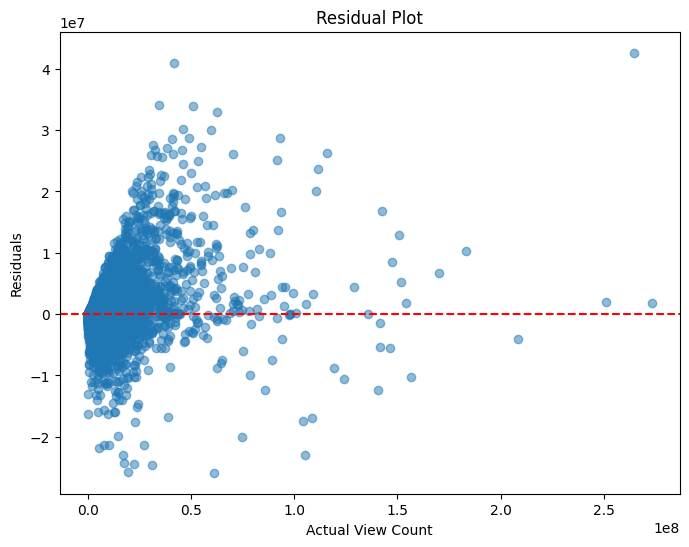

In [22]:
# Residual plot for random forest
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel('Actual View Count')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

In [142]:
#XG Boost without tuning
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features (X) and target variable (y)
x = ['likes', 'dislikes', 'comment_count', 'categoryId','title_frequency_sum','tag_frequency_sum','days_to_trend']
y = dataset['view_count']
X = dataset[x]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Further split the training set into train and tune sets
X_train, X_tune, y_train, y_tune = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Initialize XGBoost regressor
xgb_model = XGBRegressor()

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the tune set
y_tune_pred = xgb_model.predict(X_tune)

# Evaluate the model on the tune set
mse_tune = mean_squared_error(y_tune, y_tune_pred)
r2_tune = r2_score(y_tune, y_tune_pred)

print(f"Mean Squared Error on Tune Set: {mse_tune}")
print(f"R^2 Score on Tune Set: {r2_tune}")

# Make predictions on the test set
y_test_pred = xgb_model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error on Test Set: {mse_test}")
print(f"R^2 Score on Test Set: {r2_test}")

Mean Squared Error on Tune Set: 3408888638958.838
R^2 Score on Tune Set: 0.9158958895836634
Mean Squared Error on Test Set: 3650709620409.7944
R^2 Score on Test Set: 0.920137602392218


In [143]:
#XG Boost with tuning
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Define features (X) and target variable (y)
x = ['likes', 'dislikes', 'comment_count', 'categoryId','title_frequency_sum','tag_frequency_sum','days_to_trend']

y = dataset['view_count']
X = dataset[x]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Further split the training set into train and tune sets
X_train, X_tune, y_train, y_tune = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Initialize XGBoost regressor
xgb_model = XGBRegressor()

# Define hyperparameter grid for tuning
param_grid = {

    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],

}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to create a tuned XGBoost model
tuned_xgb_model = XGBRegressor(**best_params)

# Fit the tuned model to the training data
tuned_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = tuned_xgb_model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error on Test Set: {mse_test}")
print(f"R^2 Score on Test Set: {r2_test}")


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Mean Squared Error on Test Set: 3177500918667.48
R^2 Score on Test Set: 0.9304894477646157
